In [1]:
import os
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
def crop_50(image_path,save_path,daxiao=50):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w = img.shape[0:2]
    img_name = os.path.basename(image_path).split('.')[0]
    for i in range(0,h,daxiao):
        for j in range(0,w,daxiao):
            p = i if i+50 <= h else h-50
            q = j if j+50 <= w else w-50
            temp = img[p:p+50,q:q+50,::]
            cv2.imwrite(save_path+img_name+'_{}_{}.png'.format(p,q),temp)

In [3]:
def get_info(csv_path):
    res = []
    idx = 0
    with open(csv_path,'r') as f:
        reader = csv.reader(f)
        for row in reader:
            temp = {}
            idx += 1
            if idx > 1:
                temp['name'] = row[0]
                temp['zhi'] = row[1]
                res.append(temp)
    return res
    

In [4]:
def gen_heatmap(image_path,res):
    img = cv2.imread(image_path)
    h,w = img.shape[0:2]
    heatmap = np.zeros((h,w),dtype=float)
    count = np.zeros((h,w),dtype=float)
    image_name = os.path.basename(image_path).split('.')[0]
    for data in res:
        img_name = data['name']
        name = img_name.split('_')[0]
        if name == image_name:
#             print(image_name)
            i,j = img_name.split('_')[1:3]
            i = int(i)
            j = int(j)
            temp = data['zhi']
            heatmap[i:i+50,j:j+50] = heatmap[i:i+50,j:j+50] + float(temp)
            count[i:i+50,j:j+50] = count[i:i+50,j:j+50]+1
    count[count==0] = 999
    heatmap = heatmap /count
#     print(heatmap)
    return heatmap
    

In [5]:
def draw_box(image_path,res,topK=3,save_path=None):
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w = img.shape[0:2]
    image_name = os.path.basename(image_path).split('.')[0].split('_')[0]
    temp = []
    for data in res:
        img_name = data['name']
        name = img_name.split('_')[0]
        if name == image_name:
            temp.append(data)
    if (len(temp)==0):
        return
    filterbox = nms(temp,0.1)
    for box in filterbox:
        cv2.rectangle(img,(int(box[0]),int(box[1])),(int(box[2]),int(box[3])),(0,0,255),1)
        cv2.putText(img,str(box[4])[:6],(int(box[0]),int(box[1])),cv2.FONT_HERSHEY_COMPLEX_SMALL,0.8,(255,0,0))
    cv2.imwrite(save_path+image_name+'_nms_contour.png',img)
    plt.imshow(img)
    plt.show()   
#     temp.sort(key=lambda x: float(x['zhi']),reverse=True)
#     s = topK if topK <= len(temp) else len(temp)
#     for i in range(s):
#         p,q = temp[i]['name'].split('_')[1:3]
#         p = int(p)
#         q = int(q)
#         cv2.rectangle(img,(q,p),(q+50,p+50),(0,0,255),1)
#         key ="tumor: " + temp[i]['zhi'][:5]
#         cv2.putText(img,key,(q,p),cv2.FONT_HERSHEY_COMPLEX_SMALL,0.8,(255,0,0))
#     cv2.imwrite(save_path+image_name+'_box.png',img)
#     plt.imshow(img)
#     plt.show()
        
            
    

In [6]:
def nms(boxes,thresh):
    dets = []
    for data in boxes:
        p,q = data['name'].split('_')[1:3]
        p = int(p)
        q = int(q)
        dets.append([q,p,q+50,p+50,float(data['zhi'])])
    dets = np.array(dets)
    x1 = dets[:,0]
    y1 = dets[:,1]
    x2 = dets[:,2]
    y2 = dets[:,3]
    areas = (y2-y1+1) * (x2-x1+1)
    scores = dets[:,4]
    keep = []
    
    index = scores.argsort()[::-1]  
    while index.size >0:

        i = index[0]       # every time the first is the biggst, and add it directly
        keep.append(i)
        
        x11 = np.maximum(x1[i], x1[index[1:]])    # calculate the points of overlap 
        y11 = np.maximum(y1[i], y1[index[1:]])
        x22 = np.minimum(x2[i], x2[index[1:]])
        y22 = np.minimum(y2[i], y2[index[1:]])
        
        w = np.maximum(0, x22-x11+1)    # the weights of overlap
        h = np.maximum(0, y22-y11+1)    # the height of overlap
       
        overlaps = w*h
        
        ious = overlaps / (areas[i]+areas[index[1:]] - overlaps)
        idx = np.where(ious<=thresh)[0]
        
        index = index[idx+1]   # because index start from 1 except itself
    res = []
    for i in keep:
        res.append([dets[i][0],dets[i][1],dets[i][2],dets[i][3],dets[i][4]])
        
    return res
    

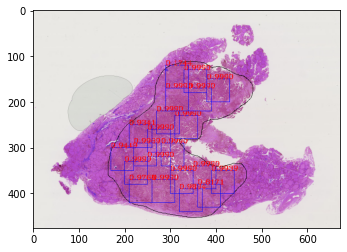

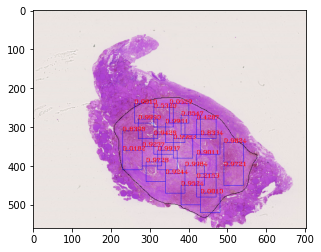

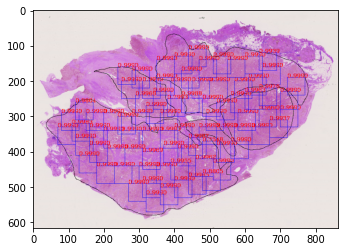

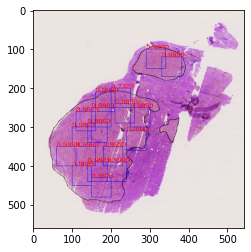

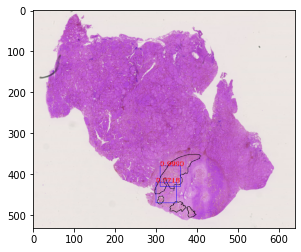

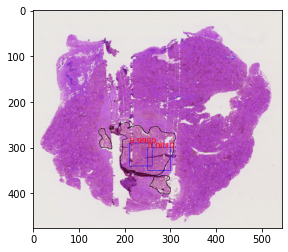

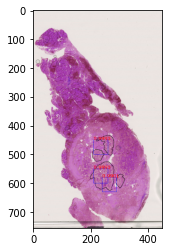

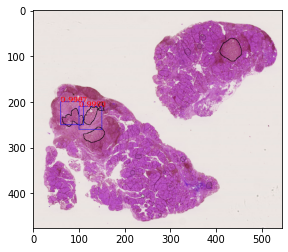

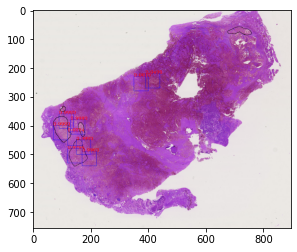

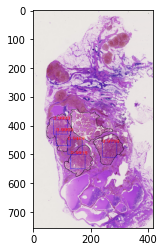

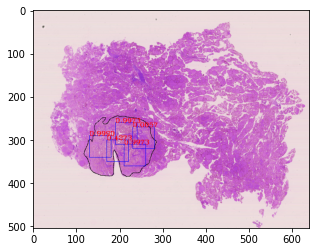

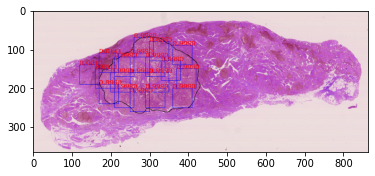

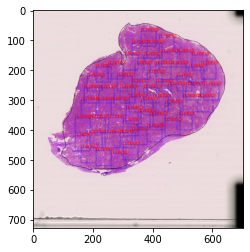

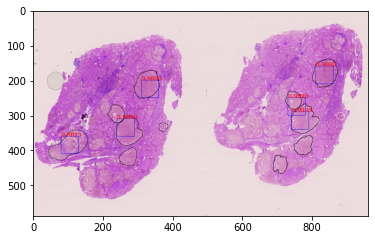

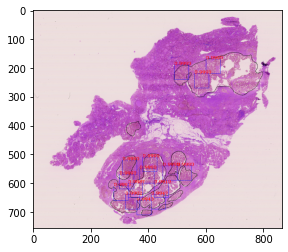

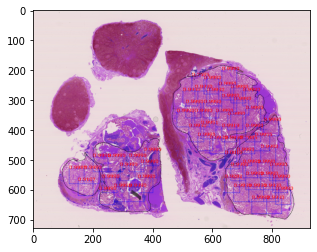

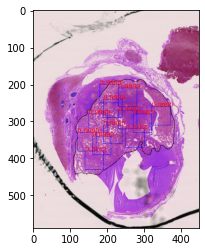

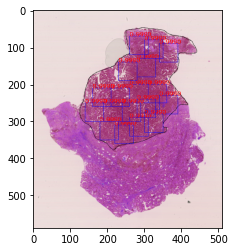

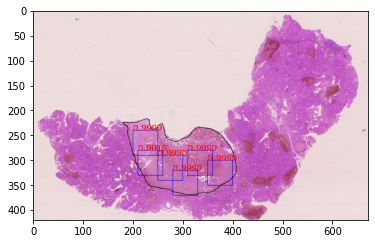

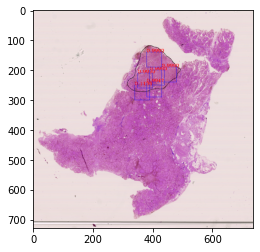

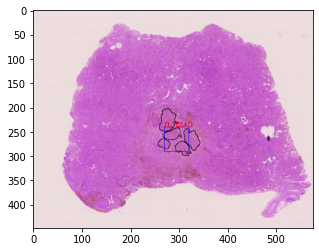

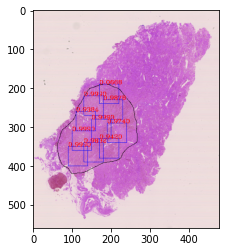

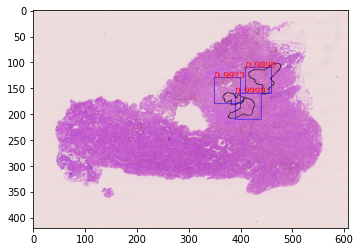

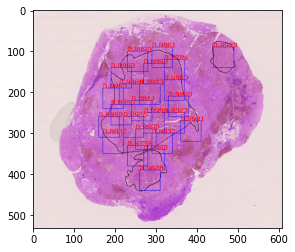

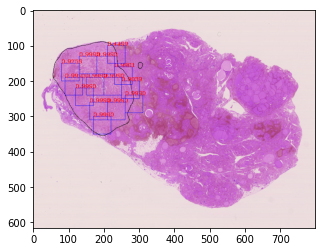

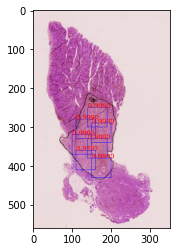

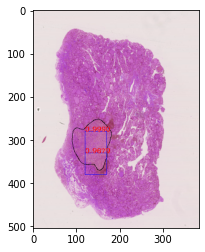

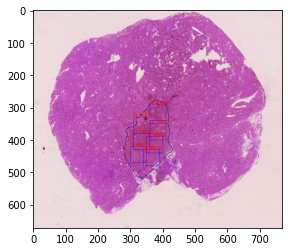

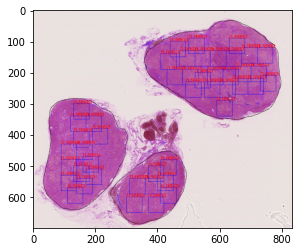

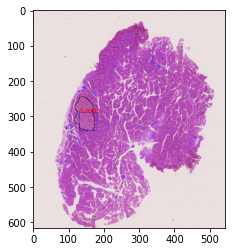

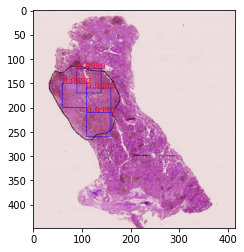

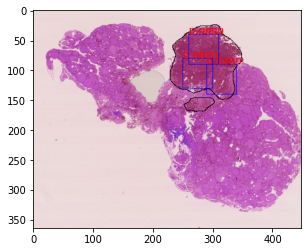

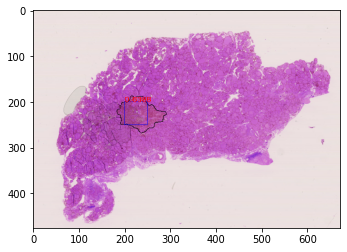

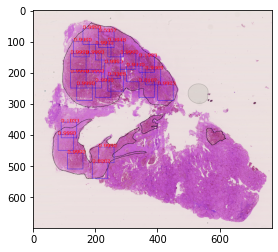

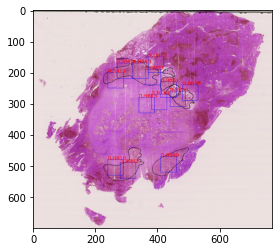

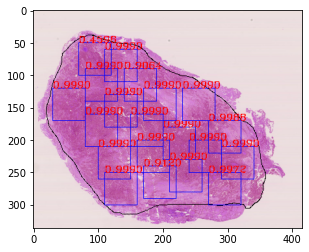

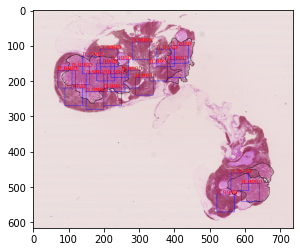

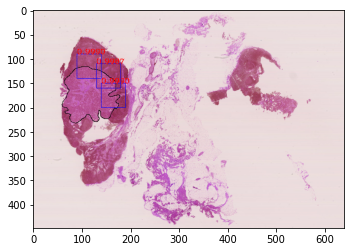

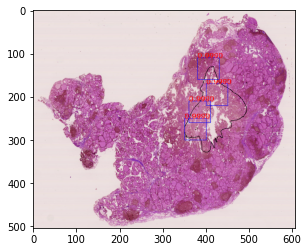

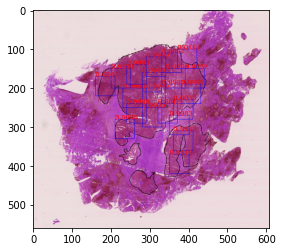

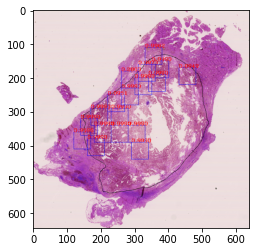

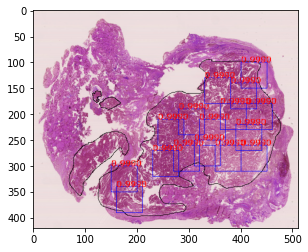

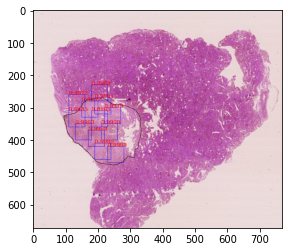

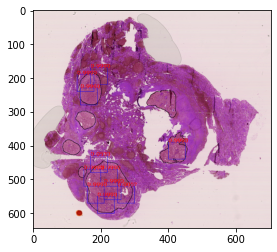

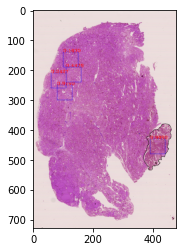

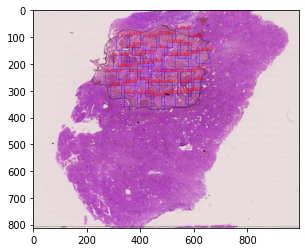

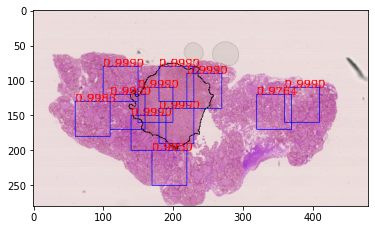

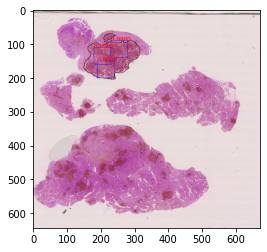

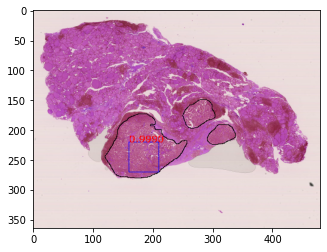

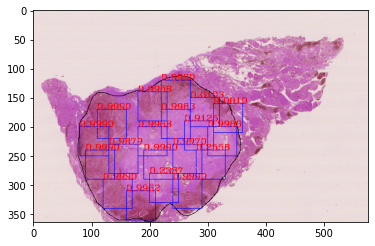

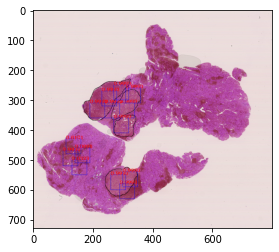

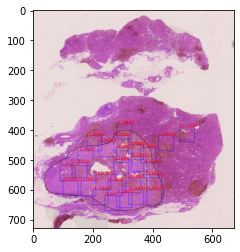

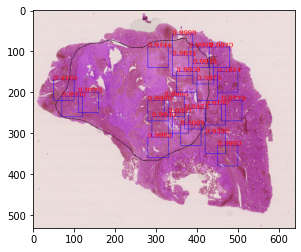

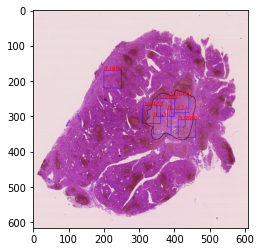

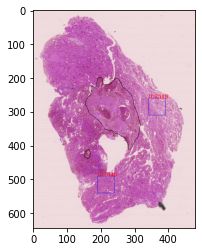

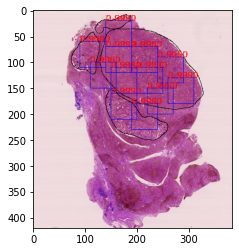

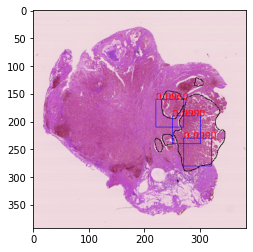

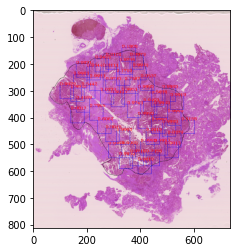

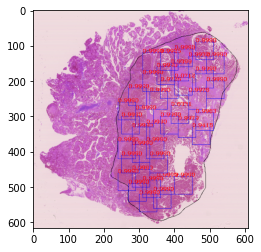

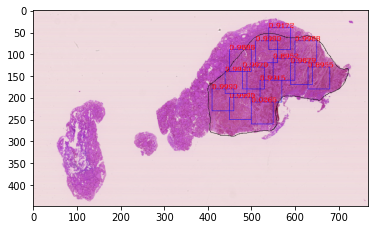

In [7]:
def main():
#     image_path = '/home/bnc/tool/HistomicsML/yourproject/classify/data/test/50017010.png'
#     save_path = '/home/bnc/tool/HistomicsML/yourproject/classify/data/test/tu/'
    csv_path = '/home/bnc/tool/HistomicsML/yourproject/classify/submissions/res/50epoch_0.001clip_1runs_alex_net.csv'
    label_path = '/home/bnc/tool/HistomicsML/yourproject/classify/label/'
#     image_path = '/home/bnc/tool/HistomicsML/yourproject/classify/images/'
    lunkuo_path = '/home/bnc/tool/HistomicsML/yourproject/classify/lunkuo/'
    save_path = '/home/bnc/tool/HistomicsML/yourproject/classify/box/'
    image_list = glob.glob(lunkuo_path+'*.png')
    res = get_info(csv_path)
    for img in image_list:
        image_name = os.path.basename(img).split('.')[0]
        draw_box(img,res,3,save_path)
#         heat_map = gen_heatmap(img,res)
#         mask = cv2.imread(label_path+image_name+'_pred.png')
#         sns.set()
#         ax = sns.heatmap(heat_map, cmap='RdBu_r')
#         plt.axis('off')
#         plt.savefig('/home/bnc/tool/HistomicsML/yourproject/classify/heatmap/'+image_name+'_hmap.png')
#         plt.show()
#         plt.imshow(mask)
#         plt.show()
    
if __name__ == '__main__':
    main()